In [134]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from ultralytics import YOLO
from PIL import Image


# ==========================================================
# Configuration
# ==========================================================

IMAGE_PATH = "Tea_Dataset_v3/Not_Tea_Making/20231226_145803.jpg"
YOLO_MODEL_PATH = "TeaLeaf_v1/Detector_YOLO26m_v3.0.pt"
RESNET_MODEL_PATH = "TeaLeaf_v1/Classifier_ResNet50_v3.0.pth"

CLASS_NAMES = {
    0: "Non-Tea / Background (Damaged or Irrelevant Material)",
    1: "Immature Shoot (Two Leaves and a Bud)",
    2: "Early Mature Leaf (Young Tender Leaf)",
    3: "Fully Mature Leaf (Standard Harvest Stage)",
    4: "Over-Mature Leaf (Aged)"
}


# ==========================================================
# Environment Setup
# ==========================================================

def get_device() -> torch.device:
    """Return the best available computation device."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def validate_paths(*paths):
    """Ensure all required files exist."""
    for path in paths:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Required file not found: {path}")


# ==========================================================
# Initialization
# ==========================================================

if __name__ == "__main__":

    # Validate required files
    validate_paths(IMAGE_PATH, YOLO_MODEL_PATH, RESNET_MODEL_PATH)

    # Setup device
    device = get_device()

    print("Environment initialized successfully.")
    print(f"Using device: {device}")


Environment initialized successfully.
Using device: cpu


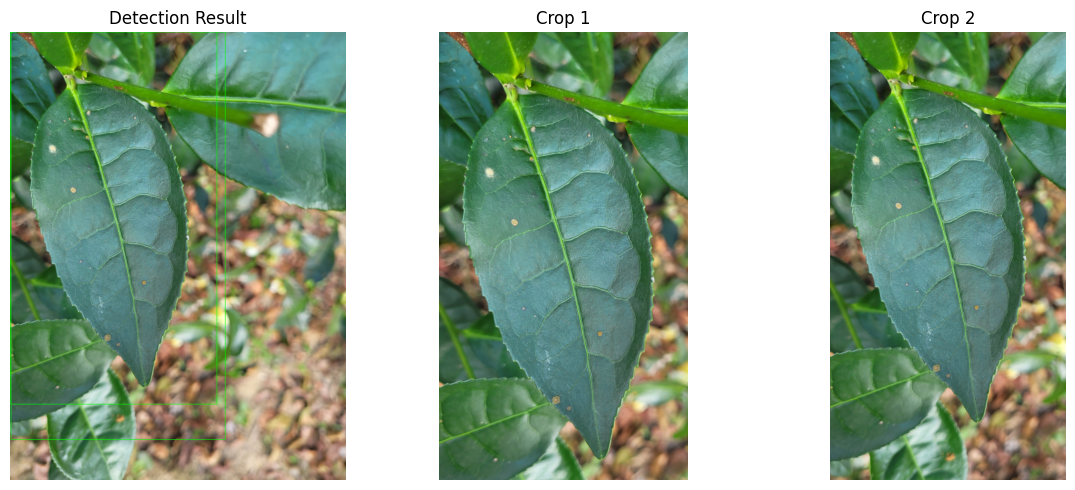

Detected and extracted 2 region(s).


In [135]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def load_yolo_model(model_path: str) -> YOLO:
    """Load and return a YOLO detection model."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"YOLO model not found at: {model_path}")
    return YOLO(model_path)


def preprocess_image(image_path: str):
    """Load image from disk and convert to RGB format."""
    clean_path = image_path.strip().replace('"', "").replace("'", "")

    if not os.path.exists(clean_path):
        raise FileNotFoundError(f"Image not found at: {clean_path}")

    image_bgr = cv2.imread(clean_path)
    if image_bgr is None:
        raise ValueError("Failed to read image. The file may be corrupted.")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb


def detect_and_crop(model: YOLO, image_rgb):
    """
    Run YOLO detection on image and return:
    - annotated image
    - list of cropped regions
    """
    height, width, _ = image_rgb.shape
    results = model(image_rgb, verbose=False)

    annotated_image = image_rgb.copy()
    crops = []

    for result in results:
        if result.boxes is None:
            continue

        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

            # Clamp coordinates to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(width, x2), min(height, y2)

            crop = image_rgb[y1:y2, x1:x2]

            if crop.size == 0:
                continue

            crops.append(crop)

            # Draw bounding box
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(
                annotated_image,
                f"#{len(crops)}",
                (x1, max(y1 - 10, 0)),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0,
                (0, 255, 0),
                2
            )

    return annotated_image, crops


def visualize_results(annotated_image, crops):
    """Display detection results and extracted crops."""
    if not crops:
        plt.figure(figsize=(8, 6))
        plt.imshow(annotated_image)
        plt.axis("off")
        plt.title("No Detections Found")
        plt.show()
        return

    num_crops = len(crops)
    fig = plt.figure(figsize=(4 * (num_crops + 1), 5))

    # Show annotated image
    ax_main = plt.subplot(1, num_crops + 1, 1)
    ax_main.imshow(annotated_image)
    ax_main.axis("off")
    ax_main.set_title("Detection Result")

    # Show each crop
    for i, crop in enumerate(crops):
        ax = plt.subplot(1, num_crops + 1, i + 2)
        ax.imshow(crop)
        ax.axis("off")
        ax.set_title(f"Crop {i + 1}")

    plt.tight_layout()
    plt.show()


# ==========================
# Execution Pipeline
# ==========================

if __name__ == "__main__":
    yolo_model = load_yolo_model(YOLO_PATH)
    image_rgb = preprocess_image(IMAGE_PATH)

    annotated_image, leaf_crops = detect_and_crop(yolo_model, image_rgb)

    visualize_results(annotated_image, leaf_crops)

    print(f"Detected and extracted {len(leaf_crops)} region(s).")


Loading ResNet classifier...
Classifying 2 detected region(s)...


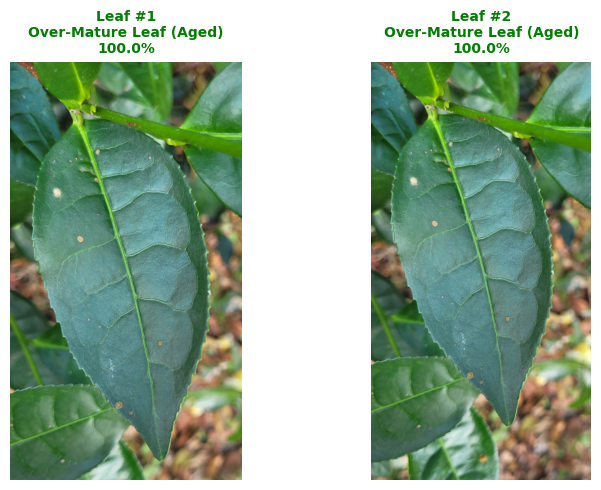

: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt


def load_resnet_classifier(model_path: str, device: torch.device, num_classes: int = 5):
    """Initialize ResNet50 architecture and load trained weights."""

    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    checkpoint = torch.load(model_path, map_location=device)

    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint)
    else:
        model = checkpoint

    model.to(device)
    model.eval()

    return model


def get_preprocessing_pipeline():
    """Return ImageNet-standard preprocessing pipeline."""
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


def classify_crops(model, crops, device, class_map):
    """Run classification on each cropped image region."""

    preprocess = get_preprocessing_pipeline()
    results = []

    for crop in crops:
        input_tensor = preprocess(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor)
            probabilities = F.softmax(logits, dim=1)[0]
            confidence, predicted_idx = torch.max(probabilities, dim=0)

        class_id = predicted_idx.item()
        label = class_map.get(class_id, "Unknown")
        score = confidence.item()

        results.append({
            "crop": crop,
            "class_id": class_id,
            "label": label,
            "confidence": score
        })

    return results


def visualize_classification(results):
    """Display classified crops with prediction labels."""

    if not results:
        print("No crops available for classification.")
        return

    num = len(results)
    plt.figure(figsize=(4 * num, 5))

    for i, result in enumerate(results):
        ax = plt.subplot(1, num, i + 1)
        ax.imshow(result["crop"])
        ax.axis("off")

        color = "red" if result["class_id"] == 0 else "green"

        ax.set_title(
            f"Leaf #{i + 1}\n"
            f"{result['label']}\n"
            f"{result['confidence']:.1%}",
            color=color,
            fontweight="bold",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


# ==========================================================
# Execution
# ==========================================================

if not leaf_crops:
    print("No crops found. Please run detection stage first.")
else:
    print("Loading ResNet classifier...")
    classifier = load_resnet_classifier(RESNET_PATH, device)

    print(f"Classifying {len(leaf_crops)} detected region(s)...")
    classification_results = classify_crops(
        classifier,
        leaf_crops,
        device,
        CLASS_NAMES
    )

    visualize_classification(classification_results)
